In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re

In [7]:
hatePath = './../Datasets/hatevsNoHate.txt'

In [8]:
df = pd.read_csv(hatePath)
df.head()

,label,tweet
0,0,I got hicks lol
1,0,"graham crackers with marshmallows, the little ..."
2,0,Uncalled for &#8220;@NoBeeetch: All trash
3,0,@imdevincarlson trash*@imgooby you're not funn...
4,0,&#187; http://t.co/f9nzpbbvrP


In [9]:
hate_tweet = df[df.label == 1]
hate_tweet.head()

,label,tweet
39500,1,"Bitch fuck yo nigga, what's up with that pussy..."
39501,1,@Campos_uli is a fag #hesgay@CarelessOne92 you...
39502,1,bi
39503,1,@DefendWallSt those little #ISIS faggots usual...
39504,1,RT @ivanrabago_: @staycoolwheels @Studhardt22 ...


In [10]:
normal_tweet = df[df.label == 0]
normal_tweet.head()

,label,tweet
0,0,I got hicks lol
1,0,"graham crackers with marshmallows, the little ..."
2,0,Uncalled for &#8220;@NoBeeetch: All trash
3,0,@imdevincarlson trash*@imgooby you're not funn...
4,0,&#187; http://t.co/f9nzpbbvrP


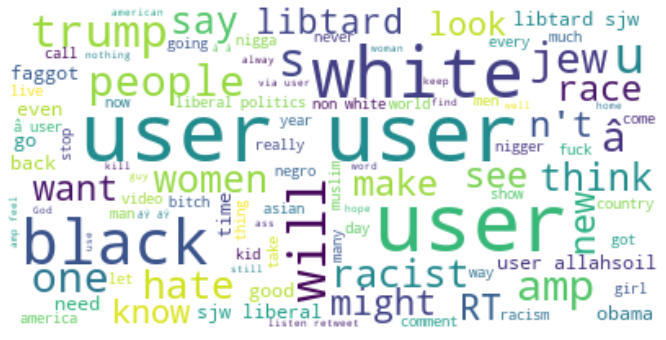

In [11]:
# Hate Word clouds
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in hate_tweet.tweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
#distributions
df_Stat=df[['label','tweet']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,0,39500,91.585708
1,1,3629,8.414292


In [13]:
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [14]:
df['processed_tweets'] = df['tweet'].apply(process_tweet)
df.head()

,label,tweet,processed_tweets
0,0,I got hicks lol,i got hicks lol
1,0,"graham crackers with marshmallows, the little ...",graham crackers with marshmallows the little m...
2,0,Uncalled for &#8220;@NoBeeetch: All trash,uncalled for 8220 all trash
3,0,@imdevincarlson trash*@imgooby you're not funn...,trash you re not funny trash that s hoser eh t...
4,0,&#187; http://t.co/f9nzpbbvrP,187 http t co f9nzpbbvrp


In [15]:
#As this dataset is highly imbalance we have to balance this by over sampling
cnt_non_fraud = df[df['label'] == 0]['processed_tweets'].count()
df_class_fraud = df[df['label'] == 1]
df_class_nonfraud = df[df['label'] == 0]
df_class_fraud_oversample = df_class_fraud.sample(cnt_non_fraud, replace=True)
df_oversampled = pd.concat([df_class_nonfraud, df_class_fraud_oversample], axis=0)

print('Random over-sampling:')
print(df_oversampled['label'].value_counts())

Random over-sampling:
0    39500
1    39500
Name: label, dtype: int64


In [16]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X = df_oversampled['processed_tweets']
y = df_oversampled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [18]:
x_train_counts = count_vect.fit_transform(X_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [19]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(63200, 42557)
(63200, 42557)


In [26]:
x_test_counts = count_vect.transform(X_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [2]:
import pickle

def save_model(name, model):
    with open(name, 'wb') as fid:
        pickle.dump(model, fid) 
        
def load_model(name):
    with open(name, 'rb') as fid:
        return pickle.load(fid)

In [119]:
#Building XGBoost Model
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)
model_bow.fit(x_train_tfidf,y_train)

[02:44:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.9, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
#save_model('XGBClassifier.pkl', model_bow)

In [121]:
predict_xgb = model_bow.predict(x_test_tfidf)

In [122]:
print(confusion_matrix(y_test,predict_xgb))
print(classification_report(y_test,predict_xgb))

[[7146  723]
 [ 627 7304]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      7869
           1       0.91      0.92      0.92      7931

    accuracy                           0.91     15800
   macro avg       0.91      0.91      0.91     15800
weighted avg       0.91      0.91      0.91     15800



In [132]:
#SVM Model
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(x_train_tfidf,y_train)

LinearSVC()

In [133]:
save_model('svm.pkl', lin_clf)


In [30]:
a = np.array(["I hate people"])
b = a.reshape(())
model = load_model('svm.pkl')
x = model.predict()

ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

In [135]:
predict_svm = lin_clf.predict(x_test_tfidf)
predict_svm

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [126]:
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,predict_svm))
print(classification_report(y_test, predict_svm))

[[7371  498]
 [  37 7894]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.96      7869
           1       0.94      1.00      0.97      7931

    accuracy                           0.97     15800
   macro avg       0.97      0.97      0.97     15800
weighted avg       0.97      0.97      0.97     15800



In [86]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [87]:
logreg = LogisticRegression(random_state=42)

In [88]:
#Building Logistic Regression  Model
logreg.fit(x_train_tfidf,y_train)

LogisticRegression(random_state=42)

In [89]:
#save_model('LogisticRegression.pkl', logreg)

In [90]:
predict_log = logreg.predict(x_test_tfidf)

In [91]:
print(confusion_matrix(y_test,predict_log))
print(classification_report(y_test, predict_log))

[[7317  585]
 [ 164 7734]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      7902
           1       0.93      0.98      0.95      7898

    accuracy                           0.95     15800
   macro avg       0.95      0.95      0.95     15800
weighted avg       0.95      0.95      0.95     15800



In [92]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train_tfidf, y_train)

MultinomialNB()

In [93]:
#save_model('NaiveBayesMultinomial.pkl', logreg)

In [94]:
predict_nb = NB.predict(x_test_tfidf)

In [95]:
print(confusion_matrix(y_test,predict_nb))
print(classification_report(y_test, predict_nb))

[[6557 1345]
 [ 129 7769]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7902
           1       0.85      0.98      0.91      7898

    accuracy                           0.91     15800
   macro avg       0.92      0.91      0.91     15800
weighted avg       0.92      0.91      0.91     15800



In [96]:
#Test Data Set
df_test = pd.read_csv("./../Datasets/test_tweets_anuFYb8.csv")
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [97]:
df_test.shape

(17197, 2)

In [98]:
df_test['processed_tweets'] = df_test['tweet'].apply(process_tweet)
df_test.head()

,id,tweet,processed_tweets
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...


In [99]:
X = df_test['processed_tweets']
x_test_counts = count_vect.transform(X)
x_test_tfidf = transformer.transform(x_test_counts)

In [100]:
df_test['predict_nb'] = NB.predict(x_test_tfidf)
df_test[df_test['predict_nb']==1]

,id,tweet,processed_tweets,predict_nb
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...,1
19,31982,thought factory: bbc neutrality on right wing ...,thought factory bbc neutrality on right wing f...,1
26,31989,chick gets fucked hottest naked lady,chick gets fucked hottest naked lady,1
33,31996,suppo the #taiji fisherman! no bullying! no ra...,suppo the taiji fisherman no bullying no racis...,1
34,31997,i say we because i'm speaking collectively. i'...,i say we because i m speaking collectively i v...,1
...,...,...,...,...
17164,49127,nobody likes me,nobody likes me,1
17167,49130,people do anything for fucking attention nowad...,people do anything for fucking attention nowadays,1
17176,49139,@user @user are the most racist pay ever!!!!!,are the most racist pay ever,1
17188,49151,"black professor demonizes, proposes nazi style...",black professor demonizes proposes nazi style ...,1


In [101]:
df_test['svm'] = NB.predict(x_test_tfidf)
df_test['reg'] = logreg.predict(x_test_tfidf)
df_test['xgb'] = model_bow.predict(x_test_tfidf)
df_test.head()

,id,tweet,processed_tweets,predict_nb,svm,reg,xgb
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,0,0,0,0
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...,1,1,0,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...,0,0,0,0
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,0,0,0,1
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...,0,0,0,0


In [102]:
file_name = 'test_predictions_Twitter Hate Analysis.csv'
df_test.to_csv(file_name,index=False)